In [1]:
import pandas as pd
import datetime 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from datetime import datetime
import time

In [2]:
from plot_functions import plot_results_by_month
from plot_functions import plot_results_with_uncertainty_by_month
from plot_functions import plot_residuals
from plot_functions import plot_train_vs_validation_loss
from plot_functions import plot_residuals_per_hour
from plot_functions import plot_hourly_residuals_distribution
from helpers import day_ahead_forecast
from helpers import extract_hourly_data
from helpers import align_predictions_to_timestamps
from helpers import picp
from helpers import pinaw

In [3]:
# Save current directory
current_directory = os.getcwd()

# Set print options to suppress scientific notation and show 3 decimal places
np.set_printoptions(suppress=True, precision=5)
pd.options.display.float_format = '{:.5f}'.format

# Suppress all warnings globally
import warnings
warnings.filterwarnings("ignore")

## Load pre-processed data

In [5]:
file_path = os.path.join(current_directory, 'data_expanded/X_train.npy')
X_train = np.load(file_path)
file_path = os.path.join(current_directory, 'data_expanded/y_train.npy')
y_train = np.load(file_path)
file_path = os.path.join(current_directory, 'data_expanded/timestamps_train.csv')
timestamps_train = pd.read_csv(file_path, parse_dates=True)
timestamps_train = timestamps_train.index

file_path = os.path.join(current_directory, 'data_expanded/X_test.npy')
X_test = np.load(file_path)
file_path = os.path.join(current_directory, 'data_expanded/y_test.npy')
y_test = np.load(file_path)
file_path = os.path.join(current_directory, 'data_expanded/timestamps_test.csv')
timestamps_test = pd.read_csv(file_path, index_col=0, parse_dates=True)
timestamps_test = timestamps_test.index

`X_train`, `X_test`, `y_train`, `y_test` are prepared in the file `data_preprocessing.ipynb`.

In [7]:
forecast_horizon = 24 # forecast horizon for predictions

In [8]:
print('Train set dimensions:')
print(X_train.shape)
print(y_train.shape)
print('Test set dimensions:')
print(X_test.shape)
print(y_test.shape)

Train set dimensions:
(17954, 168, 32)
(17954, 24)
Test set dimensions:
(745, 168, 32)
(745, 24)


## TCN Model definition, training and evaluation 

Temporal Convolutional Networks (TCNs) are an alternative to RNNs. Unlike RNNs, which process data step-by-step, TCNs leverage convolutional operations to capture temporal patterns.

In particular, TCNs process the entire input sequence at once through multiple convolutional layers. Each convolutional filter slides across the temporal axis of the sequence, capturing local patterns in the data. To ensure that predictions at any time step depend only on the current and past inputs (not future ones), TCNs use causal convolutions. More, to capture long-range dependencies without requiring excessively deep networks or large convolutional filters, TCNs employ dilated convolutions which skip over time steps in the input based on a dilation factor. 

TCNs handle the entire input sequence in parallel by applying convolutional operations simultaneously across all time steps. This parallelism makes TCNs faster and more computationally efficient. 

Finally, as the sequence passes through multiple convolutional layers, residual connections are added to ensure that information from earlier layers can flow directly to deeper layers, enabling better gradient propagation and improving the model's ability to learn both shallow and deep representations.

The TCN processes each sequence independently. During training, overlapping sequences ensure robust learning of temporal patterns, capturing seasonality, trends, and fluctuations in the data. At test time, only the last sequence is used to predict the entire forecast horizon (e.g., the next 24 hours).

In [10]:
# Check if MPS (Metal Performance Shaders) is available

import torch
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use the MPS device for Apple Silicon
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA if available
else:
    device = torch.device("cpu")  # Default to CPU if no GPU backend is available

print(f"Using device: {device}")

Using device: cpu


#### TCN Model Architecture

This Temporal Convolutional Network (TCN) is tailored for multi-step forecasting tasks. Here's a breakdown of its architecture:

1. **Input Layer**:
   - Accepts sequences of shape `(batch_size, seq_length, input_size)` where:
     - `batch_size` is the number of samples in a batch.
     - `seq_length` is the length of the time-series sequences.
     - `input_size` is the number of features per time step.

2. **Convolutional Layers**:
   - A sequence of 1D convolutional layers designed to extract temporal patterns:
     - **Input Channels**: The number of input features (`input_size`) for the first layer and the number of filters (from the previous layer) for subsequent layers.
     - **Output Channels**: Specified by `num_channels`, which defines the number of filters at each layer.
     - **Kernel Size**: Defines the receptive field of the convolution, capturing dependencies over a specified number of time steps (e.g., `kernel_size=3`).
     - **Padding**: Ensures the output sequence length remains consistent by using `padding=(kernel_size - 1)`.
     - **Non-Linearity**: A ReLU activation function introduces non-linear transformations.
     - **Dropout**: Regularization is applied after each layer to mitigate overfitting.

3. **Temporal Aggregation**:
   - The output of the final convolutional layer is reduced to a single representation per sample by extracting the last time step along the temporal dimension.

4. **Fully Connected Layer**:
   - A linear layer maps the aggregated temporal features to the forecasted output of shape `(batch_size, output_size)`, where:
     - `output_size` is the number of forecasted time steps (e.g., 24 for 24-hour prediction).

5. **Monte Carlo Dropout**:
   - The `enable_mc_dropout` method allows dropout to remain active during inference, enabling stochastic predictions for Monte Carlo Dropout sampling.

#### Workflow:
- The **`forward` method** processes the input sequence through the convolutional layers, extracts the last time step’s representation, and passes it through the fully connected layer to produce the final predictions.
- The **`enable_mc_dropout` method** ensures that dropout remains active during inference to support uncertainty estimation via Monte Carlo sampling.

This architecture leverages the hierarchical nature of convolutional layers to efficiently capture temporal dependencies, making it highly effective for time-series forecasting tasks.

In [12]:
# Define the TCN Model
import torch
import torch.nn as nn

class TemporalConvNet(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3, dropout=0.2):
        """
        Temporal Convolutional Network for Power Consumption Forecasting.

        Parameters:
            input_size (int): Number of input features.
            output_size (int): Number of output features (forecast horizon).
            num_channels (list): Number of channels in each TCN layer.
            kernel_size (int): Size of the convolution kernel.
            dropout (float): Dropout rate.
        """
        super(TemporalConvNet, self).__init__()
        layers = []
        for i in range(len(num_channels)):
            in_channels = input_size if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [
                nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=(kernel_size - 1)),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        """
        Forward pass of the TCN.

        Input:
            x: Shape (batch_size, seq_length, input_size).
        Output:
            y: Shape (batch_size, output_size).
        """
        x = x.permute(0, 2, 1)  # Change to (batch_size, input_size, seq_length)
        x = self.network(x)
        x = x[:, :, -1]  # Take the last time step
        x = self.linear(x)
        return x
    
    def enable_mc_dropout(self):
        """Enable MC Dropout by setting all dropout layers to train mode."""
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.train()

In [13]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
from torch.utils.data import DataLoader, TensorDataset

batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### TCN Model Training

1. **Model Initialization**:  
   - The LSTM model is initialized with the specified architecture, including input size, hidden size, number of layers, and dropout rate.  
   - The Adam optimizer is configured with a learning rate and L2 regularization (weight decay).  
   - The loss function used is Mean Squared Error (MSE).

2. **Mini-Batch Training**:  
   - Training data is divided into mini-batches for efficient computation.  
   - For each batch:  
     - Predictions are made using the model.  
     - Loss is computed using the MSE criterion.  
     - Gradients are backpropagated, and model parameters are updated using the optimizer.  
   - Training loss for the epoch is averaged and stored.

3. **Validation**:  
   - At the end of each epoch, the model is evaluated on the validation set.  
   - Validation loss is computed without updating the model weights (using `torch.no_grad()`).

4. **Early Stopping**:  
   - Monitors validation loss to decide when to stop training.  
   - If validation loss improves, the best model is saved.  
   - If no improvement is observed for a predefined number of epochs (patience limit), training halts early to prevent overfitting.
    
5. **Test Evaluation**:  
   - After training, the saved best model is loaded and evaluated on the test set.  
   - Final test loss is computed to assess the model’s generalization performance.

In [15]:
# Initialize the TCN model
input_size = X_train.shape[2]  # Features per time step
output_size = y_train.shape[1]  # Forecast horizon (24 hours)
hidden_channels = [128, 128, 128] # Number of filters per TCN layer
dropout_rate = 0.5  # Dropout to prevent overfitting
kernel_size = 3  # Convolution kernel size
model = TemporalConvNet(input_size, output_size, hidden_channels, kernel_size=kernel_size, dropout=dropout_rate).to(device)

# Optimizer
learning_rate = 1e-3  # Learning rate for Adam optimizer
weight_decay = 1e-4  # Regularization to prevent overfitting
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()  # Loss function (Mean Squared Error)

# Early stopping setup
patience_limit = 5  # Stop if validation loss doesn't improve for 5 epochs
best_val_loss = float("inf")  # Track best validation loss
patience_counter = 0  # Counter for early stopping

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop
num_epochs = 50  # Maximum number of epochs
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()  # Enable training mode
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model(batch_X)  # Forward pass
        loss = criterion(predictions, batch_y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        epoch_loss += loss.item()

    # Average epoch loss
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)  # Save train loss
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Time: {time.time() - start_time:.2f} seconds")

    # Validation and early stopping
    model.eval()  # Enable evaluation mode
    with torch.no_grad():
        val_predictions = model(X_test_tensor.to(device))
        val_loss = criterion(val_predictions, y_test_tensor.to(device)).item()
        val_losses.append(val_loss)  # Save validation loss
    print(f"Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_size': input_size,
            'output_size': output_size,
            'hidden_channels': hidden_channels,
            'dropout_rate': dropout_rate,
            'kernel_size': kernel_size,
            'X_train_tensor': X_train_tensor.cpu(),
            'X_test_tensor': X_test_tensor.cpu(),
            'y_train_tensor': y_train_tensor.cpu(),
            'y_test_tensor': y_test_tensor.cpu(),
            'batch_size': batch_size,
        }, "best_tcn_model_and_data.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print("Early stopping triggered.")
            break

# Save the losses for plotting later
loss_data = {
    "train_losses": train_losses,
    "val_losses": val_losses
}
with open("loss_data.json", "w") as f:
    json.dump(loss_data, f)


Epoch 1, Loss: 0.6902, Time: 57.34 seconds
Validation Loss: 0.8483
Epoch 2, Loss: 0.5012, Time: 60.13 seconds
Validation Loss: 0.7767
Epoch 3, Loss: 0.4566, Time: 62.04 seconds
Validation Loss: 0.7386
Epoch 4, Loss: 0.4371, Time: 62.67 seconds
Validation Loss: 0.7280
Epoch 5, Loss: 0.4273, Time: 63.93 seconds
Validation Loss: 0.7397
Epoch 6, Loss: 0.4178, Time: 64.45 seconds
Validation Loss: 0.7100
Epoch 7, Loss: 0.3922, Time: 64.20 seconds
Validation Loss: 0.6556
Epoch 8, Loss: 0.3734, Time: 66.87 seconds
Validation Loss: 0.6411
Epoch 9, Loss: 0.3665, Time: 66.00 seconds
Validation Loss: 0.6241
Epoch 10, Loss: 0.3576, Time: 64.95 seconds
Validation Loss: 0.6279
Epoch 11, Loss: 0.3533, Time: 67.14 seconds
Validation Loss: 0.6111
Epoch 12, Loss: 0.3503, Time: 67.35 seconds
Validation Loss: 0.6256
Epoch 13, Loss: 0.3500, Time: 66.40 seconds
Validation Loss: 0.6237
Epoch 14, Loss: 0.3473, Time: 66.21 seconds
Validation Loss: 0.6246
Epoch 15, Loss: 0.3469, Time: 64.43 seconds
Validation Lo

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


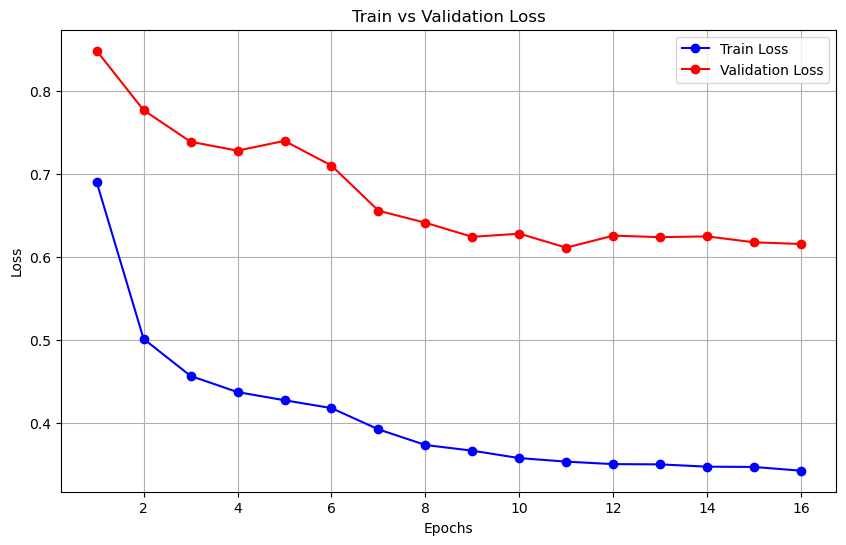

In [16]:
# Plot train and validation losses over epochs
file_path = os.path.join(current_directory, 'results/train_vs_validation_loss_TCN')
plot_train_vs_validation_loss(range(1, len(train_losses) + 1),train_losses, val_losses, file_path)

### TCN Model Evaluation
**Research Context**
The goal is to predict power consumption for the next 24 hours, aligned with real-world requirements for electricity market bidding. Predictions are made at 10 AM each day, as only data up until this point is available for making forecasts.

**Evaluation Strategy** 
The TCN model generates predictions for 24-hour windows. These windows overlap, but only predictions made specifically at 10 AM are retained for evaluation. This aligns the evaluation process with the operational constraints of the electricity market, ensuring that the model simulates real-world decision-making.

**Model Evaluation**:  
   - After training, the best model (selected via early stopping) is used to generate predictions on the test set.  
   - Predictions made at 10 AM for the next 24 hours are extracted from the test set.  
   - These predictions are compared to the actual consumption values using the accuracy metrics RMSE, MAE, ME, MAPE. 
   - The predictions are plotted against actual consumption for interpretability and visual validation.  

In [18]:
# Test the model
checkpoint = torch.load("best_tcn_model_and_data.pth")
model.load_state_dict(checkpoint['model_state_dict']) # Load the best model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor.to(device))
    test_loss = criterion(test_predictions, y_test_tensor.to(device)).item()
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.6111


In [19]:
# Save predicted and true target variable
y_pred = test_predictions.cpu().detach().numpy()  # Predictions, size: (num_test_samples, forecast_horizon)
y_true = y_test_tensor.cpu().numpy()  # Ground truth, size: (num_test_samples, forecast_horizon)

In [20]:
# Manipulate predicted target variable for plotting and accuracy evaluation 
num_samples, forecast_horizon = y_pred.shape  
prediction_timestamps = [timestamps_test[0] + pd.Timedelta(hours=i) for i in np.arange(0, num_samples+forecast_horizon-1)]
predictions = day_ahead_forecast(y_pred, prediction_timestamps)
actuals = day_ahead_forecast(y_true, prediction_timestamps)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


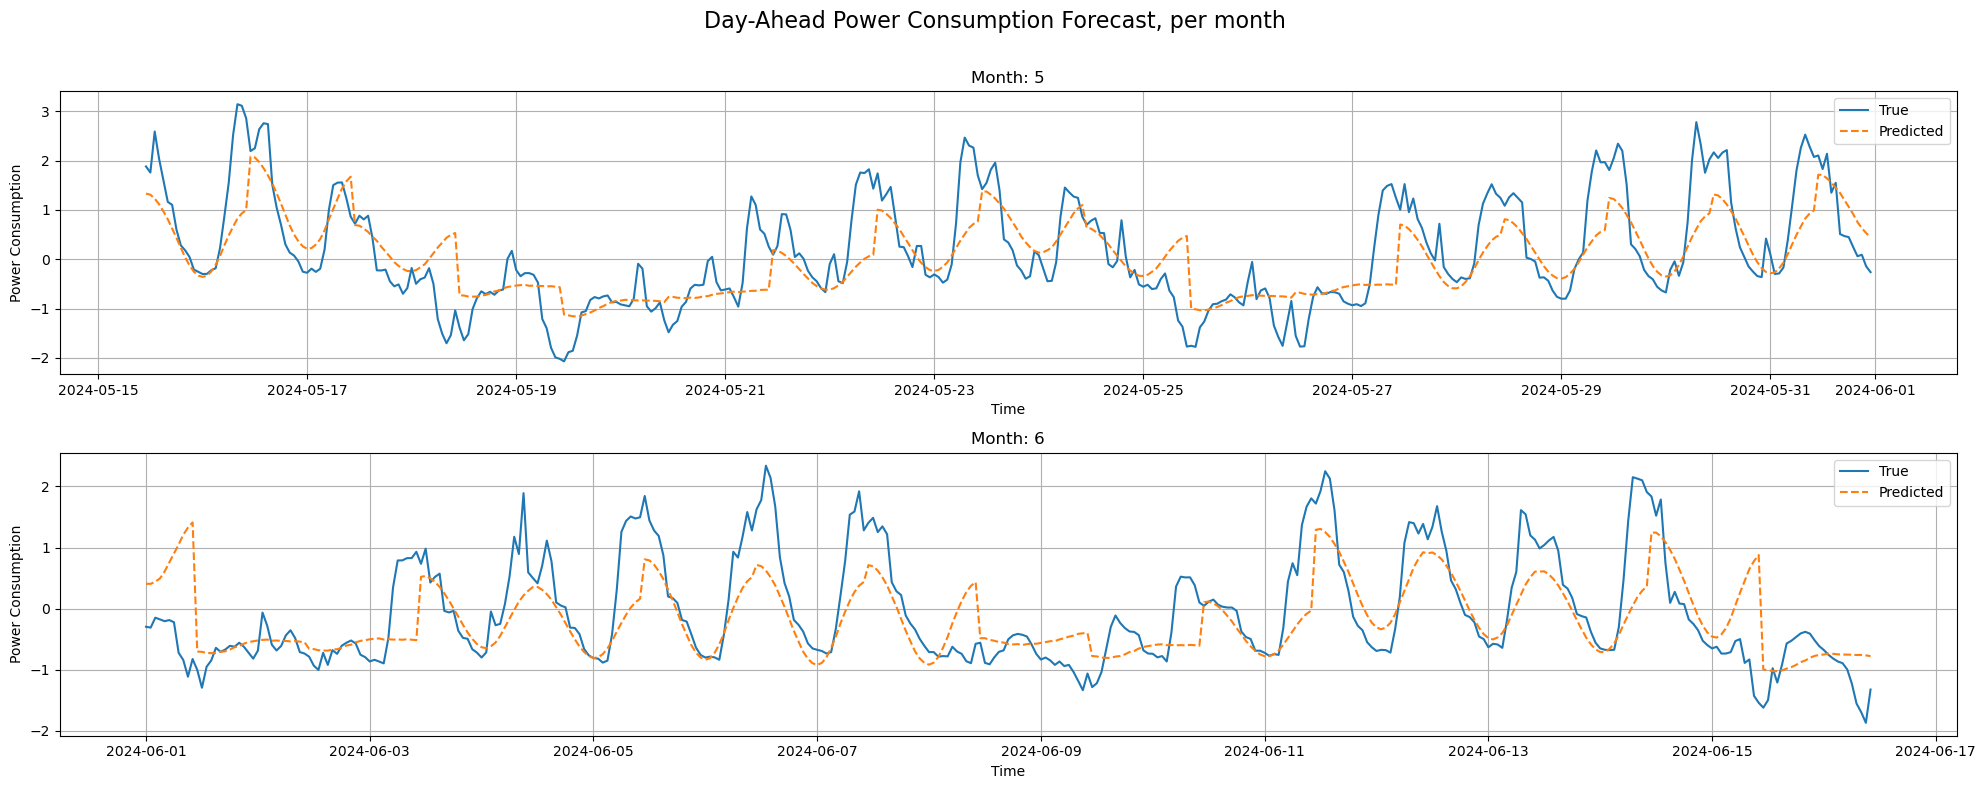

In [21]:
file_path = os.path.join(current_directory, 'results/TCN')
plot_results_by_month(predictions, actuals, "Day-Ahead Power Consumption Forecast, per month", file_path)

In [22]:
# Import metrics for predictions accuracy evaluation

# MSE
from sklearn.metrics import mean_squared_error

# RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# MAE
from sklearn.metrics import mean_absolute_error

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) # * 100

# ME
from sklearn.metrics import max_error

In [23]:
# Evaluate prediction accuracy
file_path = os.path.join(current_directory, 'results/errors.csv')
errors = pd.read_csv(file_path, index_col=0)

new_row = {'RMSE': root_mean_squared_error(actuals, predictions), 
                        'MAE': mean_absolute_error(actuals, predictions), 
                        'ME': max_error(actuals, predictions), 
                        'MAPE': mean_absolute_percentage_error(actuals, predictions)}

errors.loc['TCN'] = new_row

file_path = os.path.join(current_directory, 'results/errors.csv')
errors.to_csv(file_path)

errors

,RMSE,MAE,ME,MAPE
SARIMA,1.09877,0.89233,3.70551,4.69340
Persistence Forecast,0.91496,0.59467,3.52636,4.34736
LSTM,0.42944,0.32450,1.63404,1.50339
LSTM - include forecast,0.56858,0.40957,2.90603,1.56547
TCN,0.70384,0.50120,2.43970,1.38960


### Validation of Model Assumptions with Residuals

See `LSTM.ipynb` for further explanations. 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


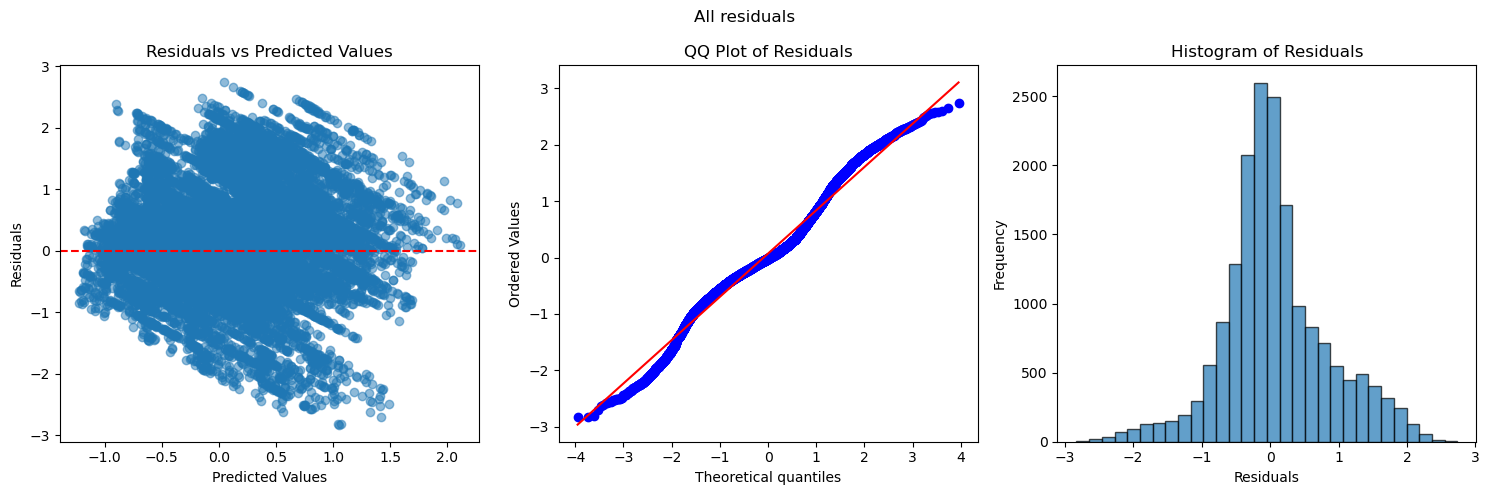

In [25]:
# All residuals
residuals_all = y_true - y_pred
file_path = os.path.join(current_directory, 'results/residuals_plot_TCN')
title = 'All residuals'
plot_residuals(residuals_all, y_pred, title, file_path)

## Monte Carlo Drop Out 

MC Dropout is employed with the purpose of estimating the uncertainty in predictions. It quantifies it by sampling multiple outputs from the model under different dropout configurations. This is particularly useful when aimed at understanding model reliability.

See `LSTM.ipynb` for further explanations. 

In [28]:
def monte_carlo_predictions(model, X, num_samples=100):
    """
    Perform Monte Carlo Dropout predictions.

    Parameters:
        model (nn.Module): TCN model with MC Dropout enabled.
        X (torch.Tensor): Input tensor of shape (batch_size, seq_length, num_features).
        num_samples (int): Number of MC samples.

    Returns:
        torch.Tensor: Mean predictions.
        torch.Tensor: Prediction standard deviations (uncertainty).
    """
    model.enable_mc_dropout()  # Enable dropout during testing
    predictions = []

    for _ in range(num_samples):
        with torch.no_grad():
            predictions.append(model(X))  # Append prediction for each MC sample

    predictions = torch.stack(predictions)  # Shape: (num_samples, batch_size, output_size)
    mean_prediction = predictions.mean(dim=0)  # Mean over MC samples
    uncertainty = predictions.std(dim=0)  # Std dev over MC samples

    return mean_prediction, uncertainty

In [29]:
# Load the saved model and data
checkpoint = torch.load("best_tcn_model_and_data.pth")

# Recreate the model
model = TemporalConvNet(
    checkpoint['input_size'],
    checkpoint['output_size'],
    checkpoint['hidden_channels'],
    checkpoint['kernel_size'],
    checkpoint['dropout_rate']
).to(device)

X_test_tensor = checkpoint['X_test_tensor'].to(device)
y_test_tensor = checkpoint['y_test_tensor'].to(device)

# Load the model state dict
model.load_state_dict(checkpoint['model_state_dict'])

# Enable MC Dropout during evaluation
model.eval()
model.enable_mc_dropout()  # Enable dropout layers specifically

# Use MC Dropout for predictions
num_samples = 100  # Number of Monte Carlo samples
mean_predictions, uncertainties = monte_carlo_predictions(model, X_test_tensor.to(device), num_samples)

# Compute test loss using the mean prediction
test_loss = criterion(mean_predictions, y_test_tensor.to(device)).item()
print(f"Test Loss (MC Dropout): {test_loss:.4f}")

# Convert results to numpy arrays for further analysis
mean_predictions_np = mean_predictions.cpu().numpy()  # Mean predictions
uncertainties_np = uncertainties.cpu().numpy()  # Prediction uncertainties
y_true = y_test_tensor.cpu().numpy()  # Ground truth

Test Loss (MC Dropout): 0.6094


In [30]:
# Save mean and standard deviation of predicted variable and true target variable
mean_predictions = day_ahead_forecast(mean_predictions_np, prediction_timestamps)
uncertainties = day_ahead_forecast(uncertainties_np, prediction_timestamps)
actuals = day_ahead_forecast(y_true, prediction_timestamps)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


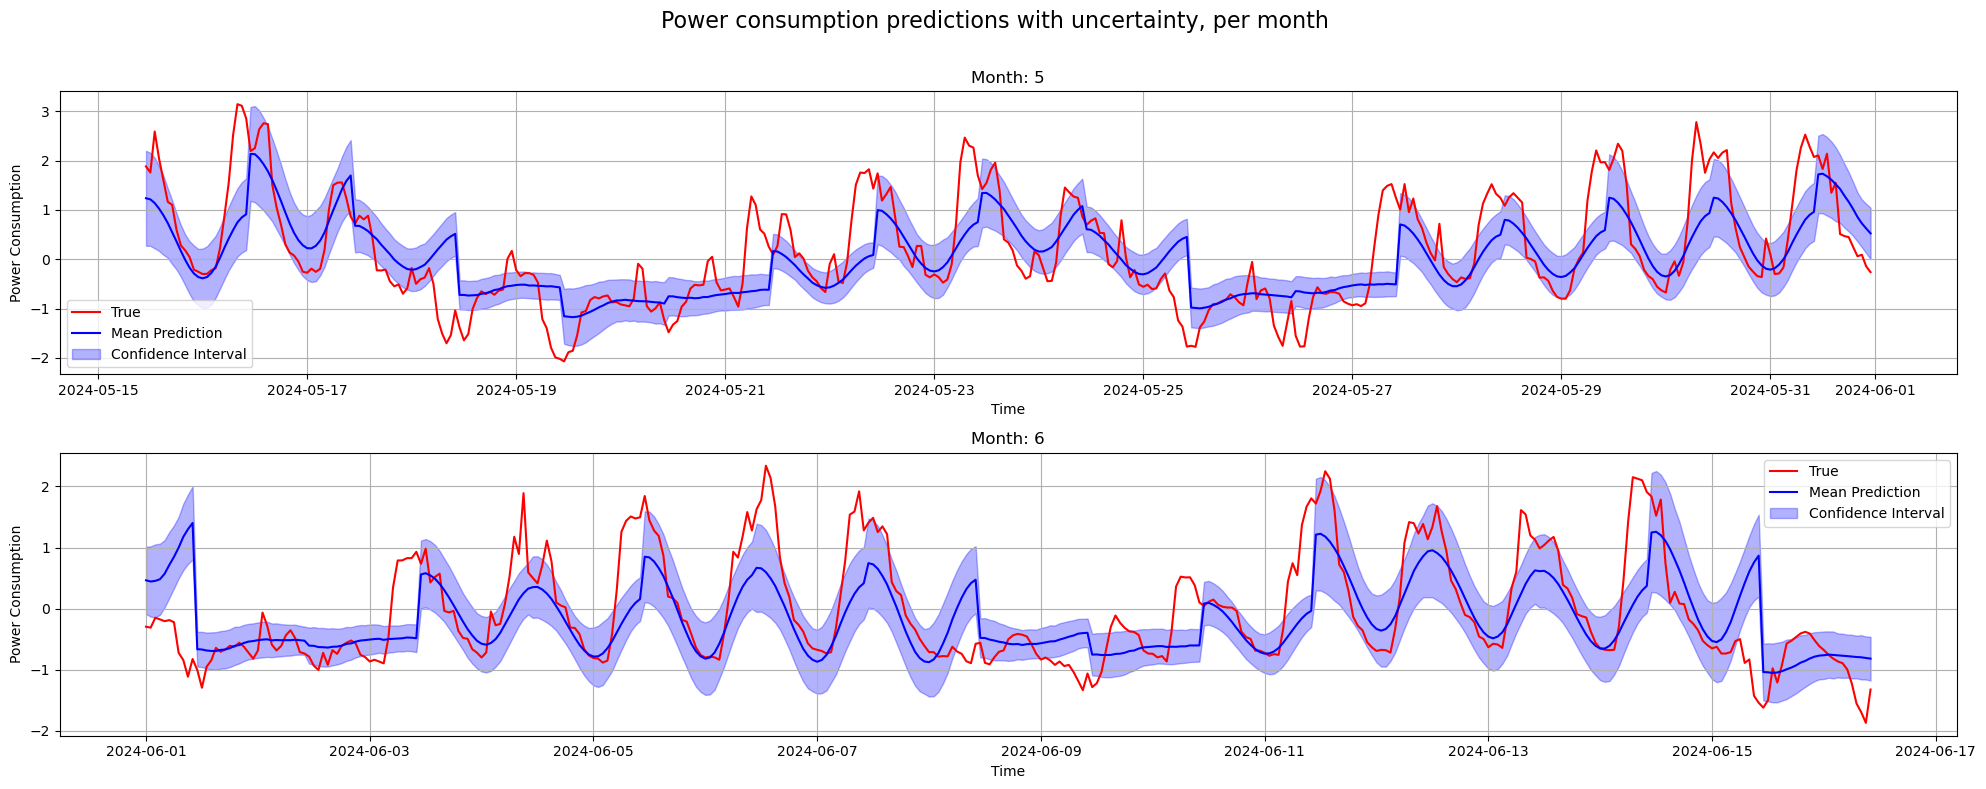

In [31]:
# Plot mean and confidence interval of predicted target variable vs true target variable
confidence_level = 1.96
file_path = os.path.join(current_directory, 'results/TCN_MCDropOut')
plot_results_with_uncertainty_by_month(mean_predictions, uncertainties, confidence_level, actuals, 'Power consumption predictions with uncertainty, per month', file_path)

### Uncertainty of predictions 

See `LSTM.ipynb` for further explanations. 

In [33]:
file_path = os.path.join(current_directory, 'results/uncertainty_evaluation.csv')
uncertainty_evaluation = pd.read_csv(file_path, index_col=0)
new_row = {'PICP': picp(actuals, mean_predictions - confidence_level * uncertainties, mean_predictions + confidence_level * uncertainties), 
                        'PINAW': pinaw(actuals, mean_predictions - confidence_level * uncertainties, mean_predictions + confidence_level * uncertainties)}

uncertainty_evaluation.loc['TCN'] = new_row
file_path = os.path.join(current_directory, 'results/uncertainty_evaluation.csv')
uncertainty_evaluation.to_csv(file_path) 

uncertainty_evaluation

,PICP,PINAW
LSTM,0.26953,0.05355
TCN,0.63281,0.18210
